## Imports

In [1]:
import pickle
import numpy as np
from lightgbm import LGBMClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from tqdm import tqdm_notebook

## Load data

In [2]:
X_train, y_train, X_train_skel_features = None, None, None
with open("data/train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("data/test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]

## Create data for boosting

In [3]:
def features(data):
    res = []
    
    res.append(list(map(len,data)))
    res.append(list(map(np.mean,data)))
    res.append(list(map(np.sum,data)))
    res.append(list(map(np.std,data)))
    res.append(list(map(lambda x: np.max(x) - np.min(x),data)))

    for i in tqdm_notebook(range(0,110,10)):
        res.append(list(map(lambda x: np.percentile(x, i),data)))

    take_each_8 = lambda arrays, idx: map(lambda array: array[idx::8], arrays)
    
    parsed = [list(take_each_8(data, i)) for i in range(8)]

    for i in tqdm_notebook(range(8)):
        res.append(list(map(len,parsed[i])))
        res.append(list(map(np.mean,parsed[i])))
        res.append(list(map(np.sum,parsed[i])))
        res.append(list(map(np.std,parsed[i])))
        res.append(list(map(lambda x: np.max(x) - np.min(x),parsed[i])))
        res.append(list(map(lambda x: Counter(x).most_common()[0][0], parsed[i])))
        res.append(list(map(lambda x: Counter(x).most_common()[0][1], parsed[i])))
        for j in tqdm_notebook(range(0,110,10)):
            res.append(list(map(lambda x: np.percentile(x, j),parsed[i])))
            
    return np.vstack(res).T

data_train = features(X_train_skel_features)
np.save('data_train', data_train)

data_test = features(X_test_skel_features)
np.save('data_test', data_test)

## Fit model

In [4]:
%%time
model = LGBMClassifier()
model.fit(data_train, y_train)

CPU times: user 6h 42min 41s, sys: 1min 4s, total: 6h 43min 46s
Wall time: 12min 37s


## Score model

In [5]:
pred = model.predict(data_test)
print('Accuracy ', accuracy_score(y_test, pred))
print('F1_score ', f1_score(y_test, pred, average='macro'))

Accuracy  0.9314
F1_score  0.9304335748468722


/cephfs/home/tushin/kirill/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Plot importance

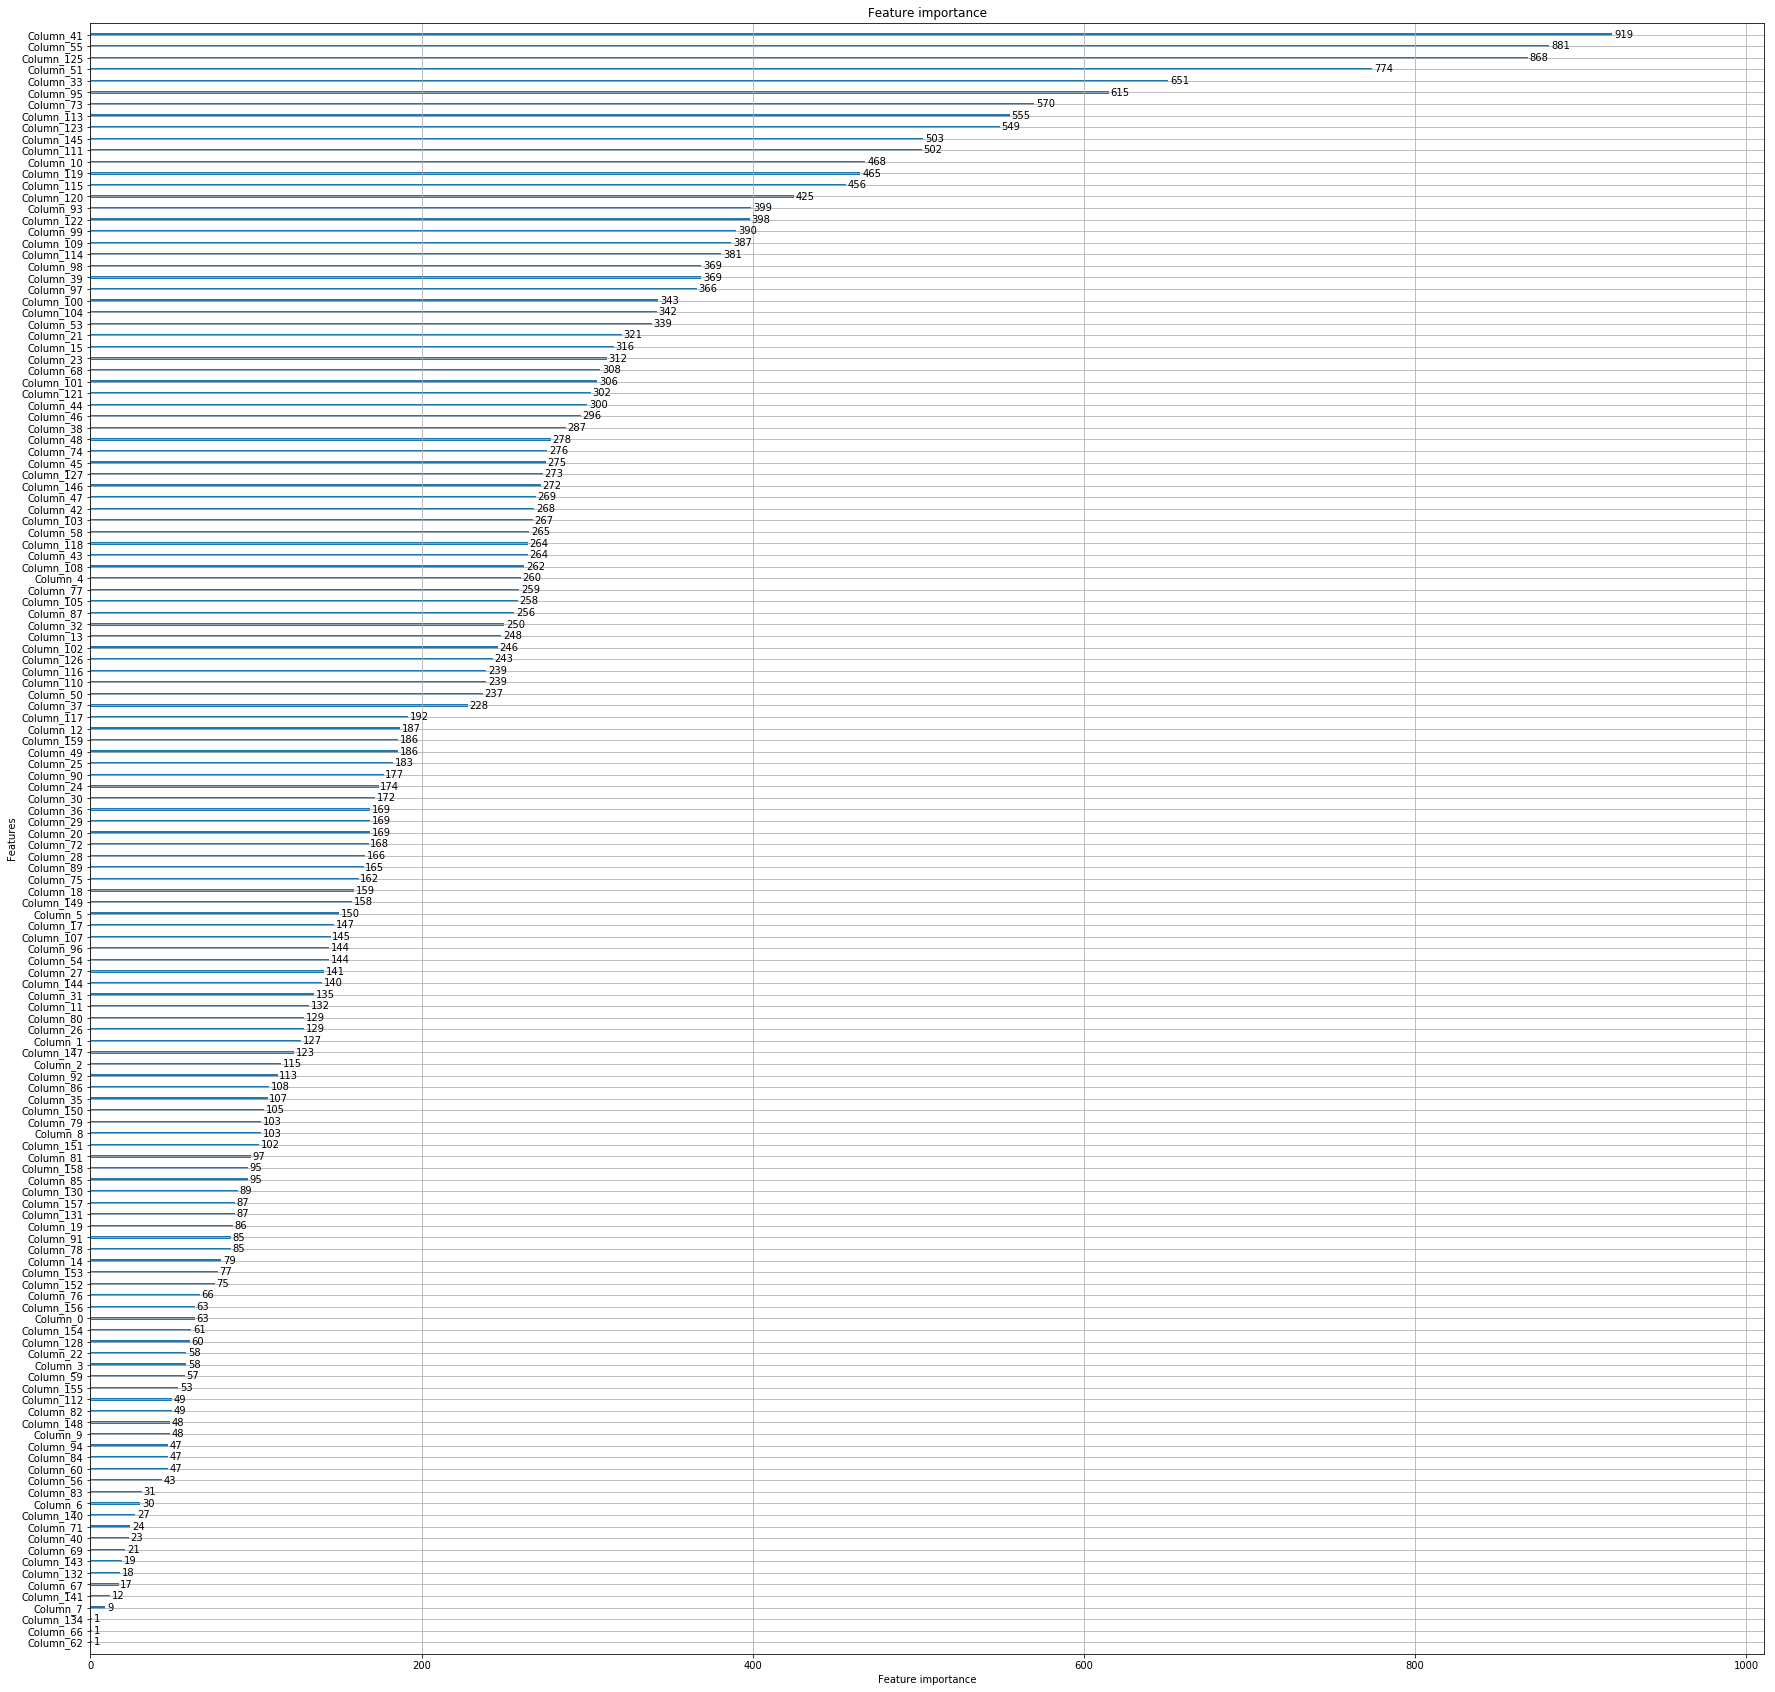

In [6]:
fig, ax = plt.subplots(figsize=(30,30))
plot_importance(model, ax=ax)